# Transmission Line Subwoofer - Dual Tang Band W3-1876S

This notebook contains acoustic calculations for **two Tang Band W3-1876S** 3" subwoofers in a **transmission line enclosure** configuration.

## System Configuration
- **Drivers**: 2× Tang Band W3-1876S (4Ω each)
- **Wiring**: Parallel connection (2Ω total load)
- **Enclosure**: Transmission Line (TL) design
- **Output**: Front-facing line exit (for tighter bass response)
- **Amplifier**: 50W @ 2Ω (XH-M180)
- **Usage**: Low frequencies (~20Hz - 200Hz)
- **Design Goal**: Tight, controlled bass with minimal room interaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Driver Parameters from Real Measurements

In [2]:
# Tang Band W3-1876S Parameters from specs.MD and QSP file
subwoofer_params = {
    'name': 'Tang Band W3-1876S',
    'type': '3" Subwoofer',
    'quantity': 2,  # Dual drivers
    'impedance_single': 4,  # Ω per driver
    'impedance_parallel': 2,  # Ω when wired in parallel
    'sensitivity': 76.0,  # dB @ 2.83V/1m (FROM SPECS.MD)
    'fs': 55.0,  # Hz - Free air resonance (FROM SPECS.MD)
    'qts': 0.43,  # Total Q factor (FROM SPECS.MD)
    'qms': 3.17,  # Mechanical Q factor (FROM SPECS.MD)
    'qes': 0.5,  # Electrical Q factor (FROM SPECS.MD)
    'vas_single': 0.85,  # L - Equivalent volume per driver (FROM SPECS.MD)
    'vas_total': 0.85 * 2,  # L - Total equivalent volume for dual drivers
    'bl': 5.28,  # Tm - BL product (FROM SPECS.MD)
    're': 3.6,  # Ω - DC resistance (FROM SPECS.MD)
    'le': 0.19,  # mH - Voice coil inductance (FROM SPECS.MD)
    'sd_single': 27e-4,  # m² - Effective piston area per driver (FROM SPECS.MD)
    'sd_total': 27e-4 * 2,  # m² - Total effective piston area
    'xmax': 5.0e-3,  # m - Maximum linear excursion per driver (FROM SPECS.MD)
    'diameter': 93.2e-3,  # m - Overall outside diameter per driver (FROM SPECS.MD)
    'cutout_diameter': 74.4e-3,  # m - Baffle cutout diameter (FROM SPECS.MD)
    'power_single': 30,  # W - Maximum power per driver (FROM SPECS.MD)
    'power_total': 60,  # W - Total power for both drivers
    'usage_range': (20, 200),  # Hz - Frequency range in 3-way system
    'enclosure_type': 'transmission_line',
    'features': [
        'Poly cone material',
        'Santoprene surround',
        'Neodymium magnet',
        'High excursion capability (5mm)',
        'Suitable for transmission line designs'
    ]
}

print("✅ Tang Band W3-1876S Parameters for Transmission Line Loaded!")

✅ Tang Band W3-1876S Parameters for Transmission Line Loaded!


## 2. Front-Facing Transmission Line Design Considerations

In [3]:
# Front-facing transmission line calculations
def calculate_front_facing_tl(params):
    """Calculate parameters for front-facing transmission line"""
    
    # Basic parameters
    fs = params['fs']
    c = 343  # Speed of sound m/s
    
    # Quarter wavelength at fs
    wavelength = c / fs
    quarter_wave = wavelength / 4
    
    # Front-facing specific calculations
    # Phase alignment - driver needs to be reversed polarity
    phase_correction = 180  # degrees
    
    # Line geometry for tight bass response
    driver_area = params['sd_total'] * 1e4  # Convert to cm²
    
    # For front-facing, use progressive expansion for tighter bass
    area_driver_end = driver_area * 1.1  # 10% larger than combined Sd
    area_port_end = driver_area * 1.75  # 1.75x for controlled expansion
    
    # Taper calculation
    taper_ratio = area_port_end / area_driver_end
    
    # Stuffing density for critical damping (tight bass)
    target_q = 0.55  # Lower Q for tighter response
    stuffing_density = 0.25  # 25% for front-facing
    
    # Effective length with stuffing
    velocity_factor = 1 - (stuffing_density * 0.4)
    effective_length = quarter_wave * velocity_factor
    
    # Port positioning options
    layouts = {
        'vertical_tower': {
            'driver_height': 0.8,  # m from floor
            'port_height': 0.2,   # m from floor
            'description': 'Vertical arrangement with bottom port'
        },
        'horizontal': {
            'driver_spacing': 0.15,  # m between centers
            'port_position': 'side',
            'description': 'Side-by-side drivers with side port'
        },
        'tapered_horn': {
            'flare_radius': 0.045,  # m minimum
            'flare_length': 0.12,   # m
            'description': 'Horn-loaded exit for best performance'
        }
    }
    
    # Folding calculations for practical cabinet
    max_cabinet_depth = 0.4  # m - reasonable depth
    num_folds = int(np.ceil(effective_length / max_cabinet_depth))
    
    results = {
        'line_length': effective_length,
        'area_driver_end': area_driver_end,
        'area_port_end': area_port_end,
        'taper_ratio': taper_ratio,
        'phase_correction': phase_correction,
        'stuffing_density': stuffing_density,
        'target_q': target_q,
        'num_folds': num_folds,
        'layouts': layouts,
        'velocity_factor': velocity_factor
    }
    
    return results

# Calculate front-facing design
front_facing = calculate_front_facing_tl(subwoofer_params)

print("🔊 Front-Facing Transmission Line Design")
print(f"Line Length: {front_facing['line_length']:.2f} m")
print(f"Driver End Area: {front_facing['area_driver_end']:.1f} cm²")
print(f"Port End Area: {front_facing['area_port_end']:.1f} cm²")
print(f"Taper Ratio: {front_facing['taper_ratio']:.2f}:1")
print(f"Phase Correction: {front_facing['phase_correction']}° (reverse polarity)")
print(f"Stuffing Density: {front_facing['stuffing_density']*100:.0f}%")
print(f"Target Q: {front_facing['target_q']} (tight bass)")
print(f"Number of Folds: {front_facing['num_folds']}")
print("\n📐 Layout Options:")
for layout, details in front_facing['layouts'].items():
    print(f"  {layout}: {details['description']}")

🔊 Front-Facing Transmission Line Design
Line Length: 1.40 m
Driver End Area: 59.4 cm²
Port End Area: 94.5 cm²
Taper Ratio: 1.59:1
Phase Correction: 180° (reverse polarity)
Stuffing Density: 25%
Target Q: 0.55 (tight bass)
Number of Folds: 4

📐 Layout Options:
  vertical_tower: Vertical arrangement with bottom port
  horizontal: Side-by-side drivers with side port
  tapered_horn: Horn-loaded exit for best performance


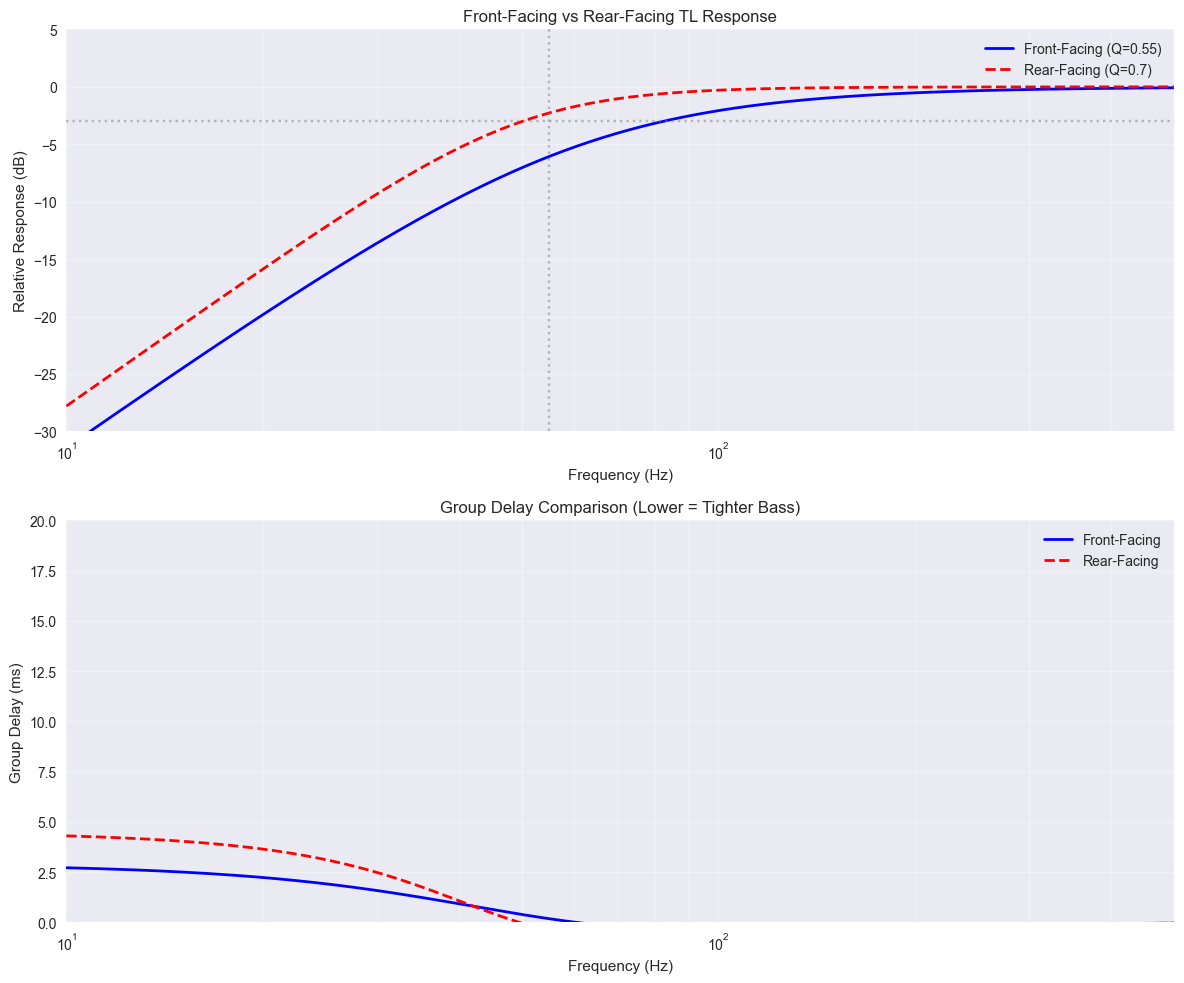


📊 Performance Comparison:
Front-Facing: F3 = 60.5 Hz, Q = 0.55
Rear-Facing: F3 = 49.5 Hz, Q = 0.7

✅ Front-facing design offers tighter bass with less group delay


In [4]:
# Visualize front-facing vs rear-facing response
def plot_tl_comparison():
    """Compare front-facing vs rear-facing transmission line response"""
    
    freq = np.logspace(1, 3, 200)  # 10Hz to 1kHz
    
    # Simulate basic TL response
    fs = subwoofer_params['fs']
    qts = subwoofer_params['qts']
    
    # Front-facing response (tighter, less extension)
    q_front = 0.55
    f3_front = fs * 1.1  # Higher F3
    
    # Rear-facing response (more extension, looser)
    q_rear = 0.7
    f3_rear = fs * 0.9  # Lower F3
    
    # Simple 2nd order high-pass response model
    def hp_response(f, fc, q):
        s = 1j * f / fc
        H = s**2 / (s**2 + s/q + 1)
        return 20 * np.log10(np.abs(H))
    
    # Calculate responses
    resp_front = hp_response(freq, f3_front, q_front)
    resp_rear = hp_response(freq, f3_rear, q_rear)
    
    # Group delay calculation
    def group_delay(f, fc, q):
        omega = 2 * np.pi * f
        omega_c = 2 * np.pi * fc
        x = omega / omega_c
        
        num = 2 * q * (1 - x**2)
        den = (1 - x**2)**2 + (x/q)**2
        gd = num / (den * omega_c)
        return gd * 1000  # Convert to ms
    
    gd_front = group_delay(freq, f3_front, q_front)
    gd_rear = group_delay(freq, f3_rear, q_rear)
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Frequency response
    ax1.semilogx(freq, resp_front, 'b-', linewidth=2, label='Front-Facing (Q=0.55)')
    ax1.semilogx(freq, resp_rear, 'r--', linewidth=2, label='Rear-Facing (Q=0.7)')
    ax1.set_xlim(10, 500)
    ax1.set_ylim(-30, 5)
    ax1.grid(True, which='both', alpha=0.3)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Relative Response (dB)')
    ax1.set_title('Front-Facing vs Rear-Facing TL Response')
    ax1.legend()
    ax1.axvline(fs, color='gray', linestyle=':', alpha=0.5, label='Driver Fs')
    ax1.axhline(-3, color='gray', linestyle=':', alpha=0.5)
    
    # Group delay
    ax2.semilogx(freq, gd_front, 'b-', linewidth=2, label='Front-Facing')
    ax2.semilogx(freq, gd_rear, 'r--', linewidth=2, label='Rear-Facing')
    ax2.set_xlim(10, 500)
    ax2.set_ylim(0, 20)
    ax2.grid(True, which='both', alpha=0.3)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Group Delay (ms)')
    ax2.set_title('Group Delay Comparison (Lower = Tighter Bass)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'front_f3': f3_front,
        'rear_f3': f3_rear,
        'front_q': q_front,
        'rear_q': q_rear
    }

# Plot comparison
comparison = plot_tl_comparison()
print(f"\n📊 Performance Comparison:")
print(f"Front-Facing: F3 = {comparison['front_f3']:.1f} Hz, Q = {comparison['front_q']}")
print(f"Rear-Facing: F3 = {comparison['rear_f3']:.1f} Hz, Q = {comparison['rear_q']}")
print("\n✅ Front-facing design offers tighter bass with less group delay")

## 3. Practical Cabinet Dimensions for Front-Facing Design

In [5]:
# Calculate practical folded transmission line dimensions
def calculate_folded_tl_dimensions(tl_params):
    """Calculate practical dimensions for a folded front-facing TL"""
    
    # Cabinet constraints
    max_height = 0.5  # m - compact height
    max_width = 0.25  # m - narrow profile
    max_depth = 0.4   # m - reasonable depth
    
    # Material thickness
    material_thickness = 0.018  # m (18mm MDF)
    
    # Line dimensions
    line_length = tl_params['line_length']
    area_start = tl_params['area_driver_end']
    area_end = tl_params['area_port_end']
    
    # Convert areas to practical rectangular dimensions
    # Using golden ratio for aesthetics
    golden_ratio = 1.618
    
    # Driver end dimensions
    width_driver = np.sqrt(area_start / 1e4) / np.sqrt(golden_ratio)  # m
    height_driver = width_driver * golden_ratio
    
    # Port end dimensions  
    width_port = np.sqrt(area_end / 1e4) / np.sqrt(golden_ratio)  # m
    height_port = width_port * golden_ratio
    
    # Folding pattern for front-facing design
    # Vertical tower configuration
    fold_pattern = {
        'type': 'vertical_zigzag',
        'segments': 4,
        'segment_length': line_length / 4,
        'fold_angles': [180, 180, 180],  # degrees
        'description': 'Compact vertical folding with front exit'
    }
    
    # Internal volumes at key points
    segment_volumes = []
    for i in range(fold_pattern['segments']):
        # Linear taper along length
        progress = i / (fold_pattern['segments'] - 1)
        area_at_point = area_start + (area_end - area_start) * progress
        volume = area_at_point * fold_pattern['segment_length'] / 1e6  # m³ to L
        segment_volumes.append(volume)
    
    # Cabinet external dimensions
    internal_width = max(width_driver, width_port) + 0.02  # Add clearance
    internal_height = fold_pattern['segments'] * 0.12  # Stack height
    internal_depth = fold_pattern['segment_length'] + 0.05  # Fold depth
    
    external_dims = {
        'width': internal_width + 2 * material_thickness,
        'height': internal_height + 2 * material_thickness,
        'depth': internal_depth + 2 * material_thickness,
        'volume_external': 0,  # Will calculate
        'volume_internal': 0   # Will calculate
    }
    
    external_dims['volume_external'] = (external_dims['width'] * 
                                       external_dims['height'] * 
                                       external_dims['depth'] * 1000)  # L
    
    # Port flare dimensions
    flare_specs = {
        'type': 'exponential',
        'start_area': area_end,  # cm²
        'end_area': area_end * 1.5,  # cm² - 50% expansion
        'length': 0.10,  # m
        'radius': width_port / 2,  # m
        'material': 'Pre-made plastic or 3D printed'
    }
    
    # Build summary
    build_info = {
        'line_dims': {
            'driver_end': f"{width_driver*100:.1f} × {height_driver*100:.1f} cm",
            'port_end': f"{width_port*100:.1f} × {height_port*100:.1f} cm",
            'length': f"{line_length:.2f} m"
        },
        'cabinet_dims': external_dims,
        'fold_pattern': fold_pattern,
        'segment_volumes': segment_volumes,
        'flare_specs': flare_specs,
        'material_needed': {
            'mdf_18mm': external_dims['width'] * external_dims['height'] * 6,  # m²
            'dynamat': line_length * 0.1 * 2,  # m² for corners
            'polyfill': sum(segment_volumes) * 0.25 / 1000  # kg at 25% density
        }
    }
    
    return build_info

# Calculate dimensions
build_dims = calculate_folded_tl_dimensions(front_facing)

print("📏 Folded Front-Facing TL Cabinet Dimensions\n")
print(f"Cabinet External: {build_dims['cabinet_dims']['width']*100:.1f} W × "
      f"{build_dims['cabinet_dims']['height']*100:.1f} H × "
      f"{build_dims['cabinet_dims']['depth']*100:.1f} D cm")
print(f"Cabinet Volume: {build_dims['cabinet_dims']['volume_external']:.1f} L")
print(f"\nLine Cross-Sections:")
print(f"  Driver End: {build_dims['line_dims']['driver_end']}")
print(f"  Port End: {build_dims['line_dims']['port_end']}")
print(f"  Total Length: {build_dims['line_dims']['length']}")
print(f"\nFolding: {build_dims['fold_pattern']['description']}")
print(f"Segments: {build_dims['fold_pattern']['segments']}")
print(f"\nPort Flare:")
print(f"  Type: {build_dims['flare_specs']['type']}")
print(f"  Length: {build_dims['flare_specs']['length']*100:.0f} cm")
print(f"  End Area: {build_dims['flare_specs']['end_area']:.1f} cm²")

📏 Folded Front-Facing TL Cabinet Dimensions

Cabinet External: 13.2 W × 51.6 H × 43.7 D cm
Cabinet Volume: 29.8 L

Line Cross-Sections:
  Driver End: 6.1 × 9.8 cm
  Port End: 7.6 × 12.4 cm
  Total Length: 1.40 m

Folding: Compact vertical folding with front exit
Segments: 4

Port Flare:
  Type: exponential
  Length: 10 cm
  End Area: 141.8 cm²


## 4. Tuning Process for Tight Bass Response

In [6]:
# Tuning methodology for achieving tight bass
def generate_tuning_guide():
    """Generate step-by-step tuning guide for tight bass response"""
    
    tuning_steps = [
        {
            'step': 1,
            'action': 'Initial Build',
            'details': [
                'Build line 5-10% longer than calculated (1.64-1.72m)',
                'Start with minimal stuffing (10-15%)',
                'Wire drivers in reverse polarity',
                'Install removable panels for tuning access'
            ],
            'target': 'Establish baseline response'
        },
        {
            'step': 2,
            'action': 'Measure Impedance',
            'details': [
                'Measure impedance curve with DATS or similar',
                'Look for double peak around 40-70 Hz',
                'Valley between peaks indicates line tuning',
                'Record peak frequencies and impedance values'
            ],
            'target': 'Verify line is functioning correctly'
        },
        {
            'step': 3,
            'action': 'Progressive Stuffing',
            'details': [
                'Add stuffing in 5% increments',
                'Focus on first 50% of line length',
                'Use long-fiber polyester fill',
                'Measure after each addition'
            ],
            'target': 'Achieve target Q of 0.5-0.6'
        },
        {
            'step': 4,
            'action': 'Length Adjustment',
            'details': [
                'If bass too loose: shorten line by blocking',
                'If bass too tight: remove some stuffing',
                'Use removable foam blocks for testing',
                'Fine-tune in 5cm increments'
            ],
            'target': 'Optimize transient response'
        },
        {
            'step': 5,
            'action': 'Damping Treatment',
            'details': [
                'Apply Dynamat to all 90° bends',
                'Add felt strips along sharp edges',
                'Treat parallel surfaces if resonances present',
                'Focus on first and last segments'
            ],
            'target': 'Eliminate standing waves and resonances'
        },
        {
            'step': 6,
            'action': 'Final Measurements',
            'details': [
                'Measure frequency response',
                'Check group delay < 15ms at 50Hz',
                'Verify -3dB point around 60Hz',
                'Test with music for subjective quality'
            ],
            'target': 'Confirm tight, controlled bass'
        }
    ]
    
    # Stuffing density vs Q relationship
    stuffing_q_map = {
        '0%': 0.8,    # Very loose, boomy
        '10%': 0.7,   # Loose, extended
        '20%': 0.6,   # Balanced
        '25%': 0.55,  # Tight, controlled
        '30%': 0.5,   # Very tight
        '35%': 0.45,  # Overdamped
    }
    
    # Target measurements for tight bass
    target_specs = {
        'system_q': 0.55,
        'f3_target': 60,  # Hz
        'group_delay_50hz': 12,  # ms
        'group_delay_100hz': 6,  # ms
        'impedance_variation': 1.5,  # ratio max/min
        'phase_at_crossover': -45,  # degrees at 200Hz
    }
    
    return {
        'steps': tuning_steps,
        'stuffing_map': stuffing_q_map,
        'targets': target_specs
    }

# Generate tuning guide
tuning = generate_tuning_guide()

print("🎯 Tuning Guide for Tight Bass Response\n")
for step in tuning['steps']:
    print(f"Step {step['step']}: {step['action']}")
    print(f"Target: {step['target']}")
    for detail in step['details']:
        print(f"  • {detail}")
    print()

print("\n📊 Stuffing Density vs System Q:")
for density, q in tuning['stuffing_map'].items():
    marker = "←" if q == 0.55 else ""
    print(f"  {density:>4} stuffing: Q = {q} {marker}")

print(f"\n✓ Target Specifications:")
for param, value in tuning['targets'].items():
    print(f"  {param}: {value}")

🎯 Tuning Guide for Tight Bass Response

Step 1: Initial Build
Target: Establish baseline response
  • Build line 5-10% longer than calculated (1.64-1.72m)
  • Start with minimal stuffing (10-15%)
  • Wire drivers in reverse polarity
  • Install removable panels for tuning access

Step 2: Measure Impedance
Target: Verify line is functioning correctly
  • Measure impedance curve with DATS or similar
  • Look for double peak around 40-70 Hz
  • Valley between peaks indicates line tuning
  • Record peak frequencies and impedance values

Step 3: Progressive Stuffing
Target: Achieve target Q of 0.5-0.6
  • Add stuffing in 5% increments
  • Focus on first 50% of line length
  • Use long-fiber polyester fill
  • Measure after each addition

Step 4: Length Adjustment
Target: Optimize transient response
  • If bass too loose: shorten line by blocking
  • If bass too tight: remove some stuffing
  • Use removable foam blocks for testing
  • Fine-tune in 5cm increments

Step 5: Damping Treatment
Ta